In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
use = pd.read_csv('eurostat/Water_Use_Data_RBD.csv', )
plant = pd.read_csv('eurostat/Treatment_plants_by_type_of_treatment_and_RBD.csv')
abstr = pd.read_csv('eurostat/Water_Abstraction_Data_RBD.csv')
waste = pd.read_csv('eurostat/Wastewater_generation_and_discharge_by_RBD.csv')
treat = pd.read_csv('eurostat/Treatment_capacity_of_wastewater_treatment_plants_by_RBD.csv')
pop = pd.read_csv('eurostat/Population_connected_to_wastewater_collection_and_treatment_systems_by_RBD.csv')
fresh = pd.read_csv('eurostat/Freshwater_Resources_Data.csv')

In [137]:
vals = ['use','plant','abstr','waste','treat','pop','fresh']

cols = [['NACE_R2','WAT_PROC'],
        ['WW_TP','WW_TPAR'],
        ['WAT_PROC','WAT_SRC'],
        ['WW_GTD','SUBSTANCE'],
        ['WW_TPAR','WW_TP'],
        ['WW_TP'],
        ['WAT_PROC'],]
for i in vals:
    
    v = vars()[i]
    v[v.Value == ':'] = np.nan
    v.drop('Flag and Footnotes',axis=1,inplace=True)
    v.dropna(subset=['Value'],inplace=True)
    v.set_index(['RBD'],inplace=True)

    vars()[i] = v


In [139]:
use = use.set_index(['NACE_R2','WAT_PROC','UNIT'],append=True)
plant = plant.set_index(['WW_TP','UNIT','WW_TPAR'],append=True)
abstr = abstr.set_index(['WAT_PROC','WAT_SRC','UNIT'],append=True)
waste = waste.set_index(['WW_GTD','SUBSTANCE','UNIT'],append=True)
treat = treat.set_index(['WW_TPAR','WW_TP','UNIT'],append=True)
pop = pop.set_index(['UNIT','WW_TP'],append=True)
fresh = fresh.set_index(['UNIT','WAT_PROC'],append=True)

In [6]:
l = set(use.index.get_level_values('RBD').values)
valsmust = ['fresh','waste','plant','pop']#,'abstr']
for v in valsmust[1:]:
    l = set(vars()[v].index.get_level_values('RBD').values) & l


In [142]:
for v in vals:
    x = vars()[v].index.get_level_values('RBD').str.contains('Danube')
    vars()[v] = vars()[v][x]
    if vars()[v].size == 0:
        print('{} is empty.'.format(v))

In [143]:
p = pd.Series()
d = pd.Series()
sub = pd.Series()
for i, v in enumerate(vals):
    for idx in cols[i]:
        x = list(set(vars()[v].index.get_level_values(idx)))
        sub = sub.append(pd.Series([idx]*len(x)),
                ignore_index=True)
        p = p.append(pd.Series(x),
                ignore_index=True)
        d = d.append(pd.Series([v]*len(x)),
                    ignore_index=True)
params = pd.DataFrame({'DataSet':d,'DataSetColumn':sub,'Parameter':p})
params.tail(4)

,DataSet,DataSetColumn,Parameter
49,pop,WW_TP,Urban and other wastewater treatment plants - ...
50,pop,WW_TP,Resident population
51,pop,WW_TP,Urban wastewater collecting system
52,fresh,WAT_PROC,Precipitation


In [144]:
l = []
for i, v in enumerate(vals):
    l.append(np.asarray(list(set(vars()[v].index.get_level_values('RBD').values))))
danube = list(set([i for item in l for i in item]))
rem = [item for item in danube if ('RBD' not in item)]
for i in rem:
    danube.remove(i) 

ds = [item[-3:-1] for item in danube]
danube

['Danube - RBD (CH)',
 'Danube - RBD (DE)',
 'Danube - RBD (HU)',
 'Danube - RBD (SI)',
 'Danube - RBD (AT)',
 'Danube - RBD (CZ)',
 'Danube - RBD (PL)',
 'Danube - RBD (SK)',
 'Danube - RBD (RO)',
 'Danube - RBD (BG)',
 'Danube - RBD (HR)']

In [145]:
header = params.Parameter.tolist()
for i, dan in enumerate(danube):
    print(dan)
    db = pd.DataFrame(index=np.arange(2000,2016))
    for i, row in params.iterrows():
        df = vars()[row.DataSet]
        subdata = df[(df.index.get_level_values(row.DataSetColumn)==row.Parameter) & (df.index.get_level_values('RBD')==dan)]
        units = list(set(subdata.index.get_level_values('UNIT').values))
        if units != []:
            for unit in units:
                ssub = subdata[subdata.index.get_level_values('UNIT') == unit]
                time = ssub.TIME.tolist()
                values = ssub.Value.astype(float).tolist()
                s = pd.DataFrame({'time':time,'values':values})
                s = s.groupby('time').mean()
                db['{} ({})'.format(row.Parameter,unit)] = s
    db.to_csv('Danube/{}.csv'.format(dan[-3:-1]))

Danube - RBD (CH)
Danube - RBD (DE)
Danube - RBD (HU)
Danube - RBD (SI)
Danube - RBD (AT)
Danube - RBD (CZ)
Danube - RBD (PL)
Danube - RBD (SK)
Danube - RBD (RO)
Danube - RBD (BG)
Danube - RBD (HR)


In [146]:
water = pd.DataFrame()
for idx in ds:
    sk =  pd.read_csv('Danube/{}.csv'.format(idx),index_col=0)

    try:
        f = sk[['Fresh surface water (Million cubic metres)','Fresh groundwater (Million cubic metres)']]
        f['ID'] =idx
        f = f.set_index('ID',append=True)
        #water[idx,'Fresh surface water (Million cubic metres)'] = sk['Fresh surface water (Million cubic metres)']
        #water[idx,'Fresh groundwater (Million cubic metres)'] = sk['Fresh groundwater (Million cubic metres)']
        water = water.append(f)
    except KeyError:
        pass

water.to_csv('Danube/water_resources.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [90]:
sk.corr(min_periods=12).dropna(axis=1,how='all').dropna(axis=0,how='all')

,Water abstraction for agriculture - irrigation (Million cubic metres),Water abstraction for public water supply (Million cubic metres),Total gross abstraction (Million cubic metres),Fresh groundwater (Million cubic metres),Fresh surface water (Million cubic metres)
Water abstraction for agriculture - irrigation (Million cubic metres),1.000000,0.474672,0.602532,0.422761,0.637134
Water abstraction for public water supply (Million cubic metres),0.474672,1.000000,0.911786,0.826999,0.881742
Total gross abstraction (Million cubic metres),0.602532,0.911786,1.000000,0.653247,0.997177
Fresh groundwater (Million cubic metres),0.422761,0.826999,0.653247,1.000000,0.615552
Fresh surface water (Million cubic metres),0.637134,0.881742,0.997177,0.615552,1.000000


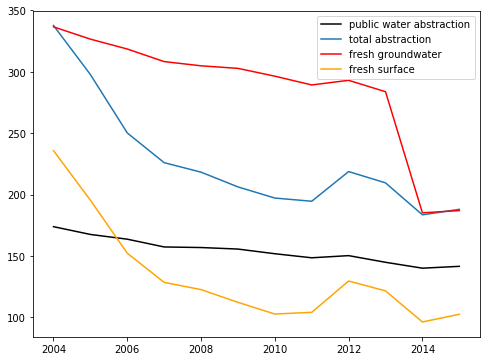

In [102]:
plt.figure(figsize=(8,6))
plt.plot(sk.index.values,
        sk['Water abstraction for public water supply (Million cubic metres)'],
        color = 'k',
        label = 'public water abstraction')
plt.plot(sk.index.values,
        sk['Total gross abstraction (Million cubic metres)'],
        label = 'total abstraction')
plt.plot(sk.index.values,
        sk['Fresh groundwater (Million cubic metres)'],
        label = 'fresh groundwater',
        color = 'red')
plt.plot(sk.index.values,
        sk['Fresh surface water (Million cubic metres)'],
        label = 'fresh surface',
        color = 'orange')
plt.legend()

In [10]:
for i, row in params.iterrows():
    df = vars()[row.DataSet]
    subdata = df[df.index.get_level_values(row.DataSetColumn)==row.Parameter]
    u = set(subdata.index.get_level_values('UNIT'))
    if len(u) != 1:
        print('{} has multiple units'.format(row.Parameter))
        unit = 0
        continue
    elif len(u) == 1:
        unit = list(u)[0]
#     plt.figure(figsize=(7,5))
#     ax = plt.subplot(111)
    for region in list(set(df.index.get_level_values('RBD').values)):
        subsubdata = subdata[subdata.index.get_level_values('RBD')==region]
subsubdata
        #subsubdata.TIME = subsubdata.TIME.astype(float) 
        #print(subsubdata.head())#.groupby(by = 'TIME').mean())
#         time = subsubdata.TIME
#         values = subsubdata.Value
#         plt.scatter(time, values,label='{}'.format(region))
#     plt.title('{} in {}'.format(row.Parameter, unit))
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Generation of wastewater - agriculture, forestry, fishing has multiple units
Generation of wastewater - industry total has multiple units
Total wastewater discharged - without treatment has multiple units
Total discharges of wastewater treatment plants (urban and other) has multiple units
Generation of wastewater - construction has multiple units
Generation of wastewater - private households has multiple units
Generation of wastewater - mining and quarrying has multiple units
Total discharges to inland waters has multiple units
Generation of wastewater - services has multiple units
Urban and industrial wastewater treatment - total inflow has multiple units
Generation of wastewater - point sources - total has multiple units
Generation of wastewater - manufacturing industries has multiple units


TIME  Value
RBD               UNIT                 WAT_PROC                    
Danube - RBD (BG) Million cubic metres Precipitation  2014.0  45026
                                       Precipitation  2015.0  31038

In [240]:

vals2 = vals[1:]
for i, v in enumerate(valsmust):
    print(vars()[v].head())
   # df = df.join(vars()[v],how='inner',rsuffix='_{}'.format(v)).dropna(axis=1, how='all')

Empty DataFrame
Columns: [Value]
Index: []
                                                                                                      Value
RBD               WW_GTD                                             SUBSTANCE UNIT                        
Danube - RBD (BG) Generation of wastewater - point sources - total   Volume    Million cubic metres  240.72
                  Generation of wastewater - agriculture, forestr... Volume    Million cubic metres    2.34
                  Generation of wastewater - industry total          Volume    Million cubic metres   98.82
                  Generation of wastewater - mining and quarrying    Volume    Million cubic metres    7.13
                  Generation of wastewater - manufacturing indust... Volume    Million cubic metres   73.07
                                                                                             Value
RBD               WW_TP                                              UNIT   WW_TPAR               
Dan

In [117]:
df.size

98996235

In [102]:
f07.Value = f07.Value.astype(float)
f07 = pd.get_dummies(f07)
d07.Value = d07.Value.astype(float)
d07 = pd.get_dummies(d07)
#d07.columns.values
print(d07.columns.values)
for col in d07.columns.values:
    if col != 'Value':
        print(col, d07[col][d07[col]!=1].values)
        if d07[col][d07[col]!=1].values.size == 0:
            d07 = d07.drop(columns=col,axis=1)
print(d07.columns.values)
d07 = d07.rename(index=str, columns={'Value':'val_{}'.format()})

['Value' 'UNIT_Number' 'WW_TPAR_Number of plants'
 'WW_TP_Urban and other wastewater treatment plants - primary treatment'
 'WW_TP_Urban and other wastewater treatment plants - secondary treatment'
 'WW_TP_Urban and other wastewater treatment plants - tertiary treatment']
UNIT_Number []
WW_TPAR_Number of plants []
WW_TP_Urban and other wastewater treatment plants - primary treatment [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
WW_TP_Urban and other wastewater treatment plants - secondary treatment [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
WW_TP_Urban and other wastewater treatment plants - tertiary treatment [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['Value'
 'WW_TP_Urban and other wastewater treatment plants - primary treatment'
 'WW_TP_Urban and other wastewater treatment plants - secondary treatment'
 'WW_TP_Urban and other wastewater treatment plants - tertiary treatment']


Value  \
RBD                     TIME            
Danube - RBD (DE)       2007   337.00   
                        2007  1006.07   
                        2007   869.01   
Rhine - RBD (DE)        2007  1190.00   
                        2007  1548.00   
                        2007  2184.00   
Moselle-Saar (DE)       2007    58.00   
                        2007   248.85   
                        2007   229.00   
Ems - RBD (DE)          2007    81.00   
                        2007    40.00   
                        2007   204.00   
Elbe / Labe - RBD (DE)  2007   506.00   
                        2007  1350.94   
                        2007   942.00   
Oder / Odra - RBD (DE)  2007    10.00   
                        2007    83.00   
                        2007    68.00   
Maas / Meuse - RBD (DE) 2007    52.00   
                        2007    12.00   
                        2007    76.11   

                              WW_TP_Urban and other wastewater treatment plants - primary treatment  \
RBD                     TIME                                                                          
Danube - RBD (DE)       2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       
Rhine - RBD (DE)        2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       
Moselle-Saar (DE)       2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       
Ems - RBD (DE)          2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       
Elbe / Labe - RBD (DE)  2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       
Oder / Odra - RBD (DE)  2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       
Maas / Meuse - RBD (DE) 2007                                                  1                       
                        2007                                                  0                       
                        2007                                                  0                       

                              WW_TP_Urban and other wastewater treatment plants - secondary treatment  \
RBD                     TIME                                                                            
Danube - RBD (DE)       2007                                                  0                         
                        2007                                                  1                         
                        2007                                                  0                         
Rhine - RBD (DE)        2007                                                  0                         
                        2007                                                  1         

In [10]:
fD = fD[fD.Value != ':']
fD.Value = fD.Value.astype(float)

In [11]:

for rbd in fD.RBD.values[0]:
    df = fD[fD.RBD == rbd]
    for type_ in df.WAT_PROC.values:
        ddf = df[df.WAT_PROC.values == type_]
        #print(ddf[['TIME','Value']].describe())
        ddf.plot(x='TIME',y='Value')
        plt.title('Region: {}, {}'.format(rbd,type_))
        

In [ ]:
precip.plot(x='TIME',y='')